In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import cv2

import matplotlib.pyplot as plt

# Anchor Boxes

In [2]:
def draw_grid(input, line_color=(0, 255, 0), thickness=1, type_= cv2.LINE_AA, pxstep=50):
    img = input.copy()
        
    cv2.rectangle(img,(0,0),(img.shape[0]-1,img.shape[1]-1),line_color,thickness)
    
    x = 0
    y = 0
    while x < img.shape[1]:
        cv2.line(img, (x, 0), (x, img.shape[0]), color=line_color, lineType=type_, thickness=thickness)
        x += pxstep

    while y < img.shape[0]:
        cv2.line(img, (0, y), (img.shape[1], y), color=line_color, lineType=type_, thickness=thickness)
        y += pxstep
        
    return img

## Immagine di esempio

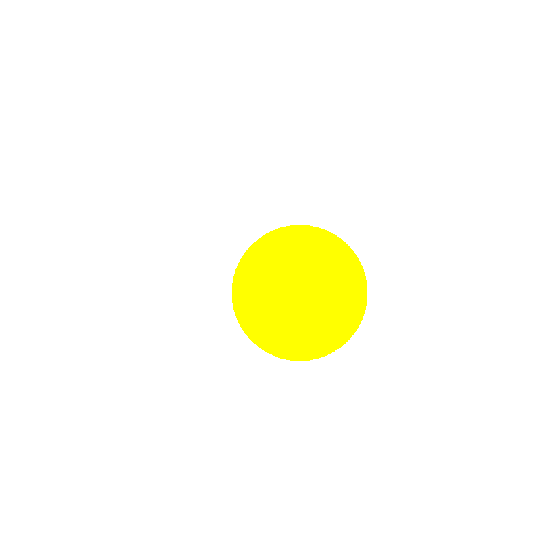

In [3]:
import numpy as np
import cv2


img = np.ones((800, 800,3),dtype = 'uint8')*255

# [y1, x1, y2, x2] format
bbox = [250,550,550,750]

x, y = 430,420
r = 100


cv2.circle(img, (x,y), r, (255, 255, 0),cv2.FILLED)


plt.figure(figsize=(10,10))

plt.imshow(img)
plt.axis('off')
plt.show()


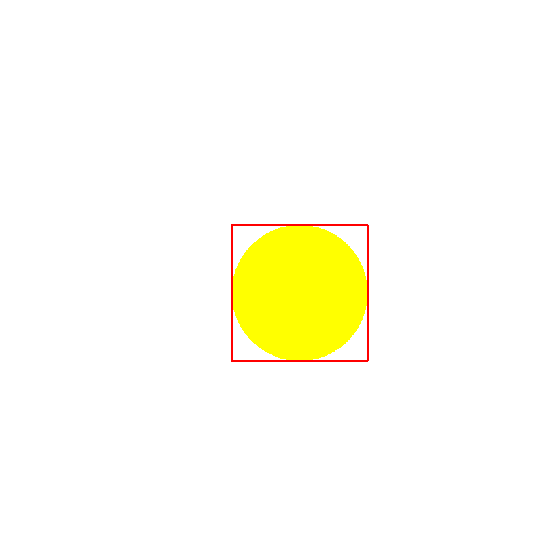

In [4]:
cv2.rectangle(img, (x-r,y-r), (x+r, y+r), (255, 0, 0),thickness=2)



plt.figure(figsize=(10,10))

plt.imshow(img)
plt.axis('off')
plt.show()



La griglia rappresenta il livello di downsample ottenuto calcolando le feature maps

In [5]:
model_ft = torchvision.models.vgg16(pretrained=True)

In [6]:
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
model_ft = model_ft.features[:-1]

In [8]:
model_ft

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [9]:
input = torch.randn((1,3,800,800))

output = model_ft(input)


In [10]:
output.shape

torch.Size([1, 512, 50, 50])

In [11]:
output[0,0,0,0]

tensor(0., grad_fn=<SelectBackward>)

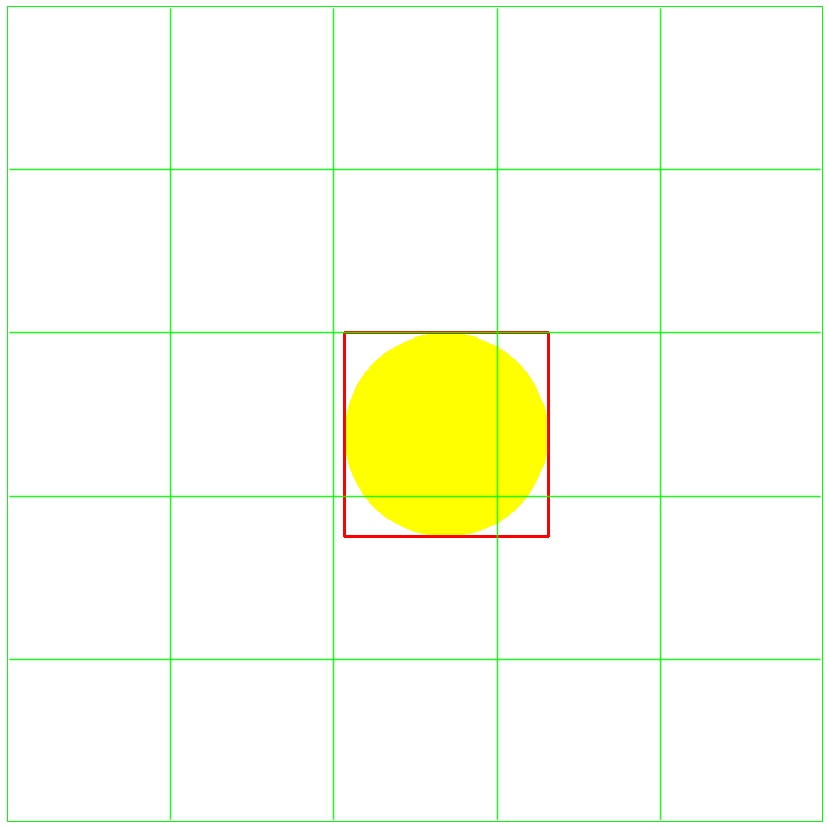

In [12]:
plt.figure(figsize=(15,15))


cell_size = 160

img_grid = draw_grid(img,pxstep=cell_size)

plt.imshow(img_grid)
plt.axis('off')
plt.show()

## Visualizzare gli anchor boxes

Generiamo la griglia degli anchor points

In [13]:
def generate_anchors(img, sub_sample, ratios=[0.5, 1, 2], anchor_scales=[0.5, 1, 2]):
    fe_size = [img.shape[0] // sub_sample, img.shape[1] // sub_sample]

    ctr_x = np.arange(sub_sample, (fe_size[0] + 1) * sub_sample, sub_sample).astype('int')
    ctr_y = np.arange(sub_sample, (fe_size[1] + 1) * sub_sample, sub_sample).astype('int')

    ctr = np.zeros((len(ctr_x) * len(ctr_y), 2)).astype('int')
        
    index = 0
    for x in range(len(ctr_x)):
        for y in range(len(ctr_y)):
            ctr[index, 1] = ctr_x[x] - (sub_sample//2)
            ctr[index, 0] = ctr_y[y] - (sub_sample//2)

            index += 1

    n_of_anchors = len(ratios) * len(anchor_scales)
    anchors = np.zeros(((fe_size[0] * fe_size[1] * n_of_anchors), 4)).astype('int')

    index = 0

    for c_id, c in enumerate(ctr):
        ctr_y, ctr_x = c
        for i in range(len(ratios)):
            for j in range(len(anchor_scales)):
                h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
                w = sub_sample * anchor_scales[j] * np.sqrt(1. / ratios[i])
                anchors[index, 0] = ctr_y - h / 2.
                anchors[index, 1] = ctr_x - w / 2.
                anchors[index, 2] = ctr_y + h / 2.
                anchors[index, 3] = ctr_x + w / 2.
                index += 1

    index_inside = np.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= 800) &
        (anchors[:, 3] <= 800)
    )[0]

    return ctr,anchors[index_inside]

In [14]:
ctr,anchors = generate_anchors(img_grid,cell_size,anchor_scales=[1,2,4])

In [15]:
anchors

array([[  0,   0, 160, 160],
       [160,   0, 320, 160],
       [126,  23, 353, 136],
       [320,   0, 480, 160],
       [286,  23, 513, 136],
       [480,   0, 640, 160],
       [446,  23, 673, 136],
       [640,   0, 800, 160],
       [ 23, 126, 136, 353],
       [  0, 160, 160, 320],
       [183, 126, 296, 353],
       [126,  13, 353, 466],
       [160, 160, 320, 320],
       [ 80,  80, 400, 400],
       [126, 183, 353, 296],
       [ 13, 126, 466, 353],
       [343, 126, 456, 353],
       [286,  13, 513, 466],
       [320, 160, 480, 320],
       [240,  80, 560, 400],
       [286, 183, 513, 296],
       [173, 126, 626, 353],
       [503, 126, 616, 353],
       [446,  13, 673, 466],
       [480, 160, 640, 320],
       [400,  80, 720, 400],
       [446, 183, 673, 296],
       [333, 126, 786, 353],
       [663, 126, 776, 353],
       [640, 160, 800, 320],
       [ 23, 286, 136, 513],
       [  0, 320, 160, 480],
       [183, 286, 296, 513],
       [126, 173, 353, 626],
       [160, 3

In [16]:
def draw_anchors(image,ctr,anchors, point_col = (0, 0, 0), anch_col = (150, 150, 150),thickness=1, type_= cv2.LINE_AA):
    im = image.copy()
    
    if ctr is not None:
        for c in ctr:
            cv2.circle(im, (c[0],c[1]), 0, point_col, thickness=5)
        
        
    for a in anchors:
        cv2.rectangle(im,(a[0], a[1]), (a[2], a[3]),anch_col,thickness)
    
    return im

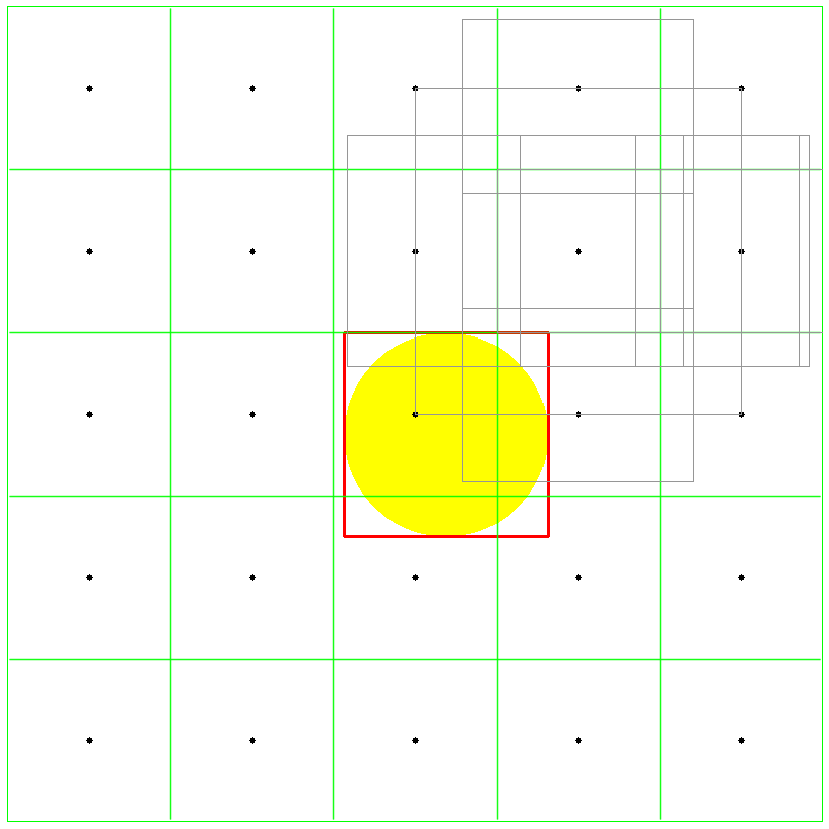

In [17]:
plt.figure(figsize=(15,15))


cell_size = 80

img_anch = draw_anchors(img_grid,ctr,anchors[22:30])#[312:321])
#img_anch = draw_anchors(img_grid,ctr,anchors)


plt.imshow(img_anch)
plt.axis('off')
plt.show()

## Region Proposal Network

In [18]:
class RegioProposalNetwork(nn.Module):
    def __init__(self,in_channels = 512, mid_channels = 512, n_anchor = 9):
        super(RegioProposalNetwork, self).__init__()
        conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        nn.init.normal(conv1.weight, mean=0, std=0.001)
        nn.init.zeros(conv1.bias)
            
        reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
        nn.init.normal(reg_layer.weight, mean=0, std=0.001)
        nn.init.zeros(reg_layer.bias)

        cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0) 
        nn.init.normal(cls_layer.weight, mean=0, std=0.001)
        nn.init.zeros(cls_layer.bias)

    
    def forward(self, x):
        x = conv1(x)
        pred_anchor_locs = reg_layer(x)
        pred_cls_scores = cls_layer(x)
        
        pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
        pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()

        pred_cls_scores  = pred_cls_scores.view(pred_cls_scores.shape[0], -1, 2)
        
        return pred_anchor_locs, pred_cls_scores
        
        

## RetinaNet

Riferimento su [github](https://github.com/kuangliu/pytorch-retinanet)

In [19]:
pt = np.linspace(0,1,2000)
pt = pt[1:]

FL= lambda gamma: -1*(1-pt)**gamma*np.log(pt)



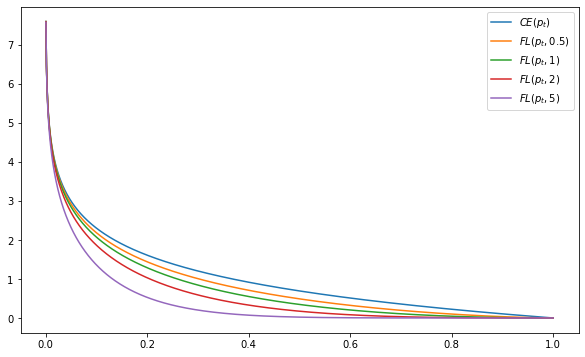

In [20]:

plt.figure(figsize=(10,6))




plt.plot(pt,FL(0),label=r'$CE(p_t)$')
plt.plot(pt,FL(0.5),label=r'$FL(p_t,0.5)$')
plt.plot(pt,FL(1),label=r'$FL(p_t,1)$')
plt.plot(pt,FL(2),label=r'$FL(p_t,2)$')
plt.plot(pt,FL(5),label=r'$FL(p_t,5)$')
plt.legend()

plt.show()
